**Updated**: 08.08.2021

In [2]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import pyasn
import requests
from mpl_toolkits.basemap import Basemap

from colors import Colors

%matplotlib inline

In [2]:
connection = sq.connect("./measurements.db")
connection.row_factory = sq.Row
asndb = pyasn.pyasn('09-06-2021.dat')

In [3]:
def getRCodeCountForProtocol(protocol):
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming AND protocol = '{}'".format(protocol), connection)
    return df.groupby("r_code", as_index = True).size().reset_index(name = "count").set_index("r_code")

def getErrorSuccessCountForProtocol(protocol):
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    success = (len(df.index) - df.isna().sum(axis = 0)).item()
    error = df.isna().sum(axis = 0).item()
    state = pd.DataFrame({ "status": ["success", "error", "error_rate"], "count": [(len(df.index) - df.isna().sum(axis = 0)).item(), df.isna().sum(axis = 0).item(), error / len(df.index)] })
    state = state.set_index("status")
    return state

def getErrorSuccessCountForQUIC():
    df = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE protocol = 'quic' AND not cache_warming AND (ip, port) IN (SELECT ip, port FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL)", connection)
    state = pd.DataFrame({ "status": ["success", "error", "error_rate"], "count": [(len(df.index) - df.isna().sum(axis = 0)).item(), df.isna().sum(axis = 0).item(), df.isna().sum(axis = 0).item() / len(df.index)] })
    state = state.set_index("status")
    return state

def getHTTPVersion():
    df = pd.read_sql_query("SELECT http_version FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'https'", connection)
    return df.groupby("http_version").size().reset_index(name = "count").set_index("http_version")

def getTLSVersions(protocol):
    df = pd.read_sql_query("SELECT tls_version FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = '{}'".format(protocol), connection)
    return df.groupby("tls_version").size().reset_index(name = "count").set_index("tls_version")

def getDoQVersions():
    df = pd.read_sql_query("SELECT q_ui_c_negotiated_protocol AS quic_negotiated_protocol FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    return df.groupby("quic_negotiated_protocol").size().reset_index(name = "count").set_index("quic_negotiated_protocol")

def getQUICVersions():
    df = pd.read_sql_query("SELECT q_ui_c_version AS quic_version FROM dns_measurements WHERE q_ui_c_version IS NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    grouped_df = df.groupby("quic_version", as_index = False).size()
    def toText(row):
        if row["quic_version"] == 4278190109:
            return "Draft 29"
        elif row["quic_version"] == 4278190112:
            return "Draft 32"
        elif row["quic_version"] == 4278190114:
            return "Draft 34"
        else:
            return "Unknown"
    
    grouped_df["version_name"] = grouped_df.apply(toText, axis = 1)
    return grouped_df.set_index("quic_version")

def getDoQPortServers():
    df = pd.read_sql_query("SELECT DISTINCT ip, port FROM dns_measurements WHERE r_code is NOT NULL AND NOT cache_warming AND protocol = 'quic'", connection)
    counter = {}
    for i, row in df.iterrows():
        if row["ip"] not in counter:
            counter[row["ip"]] = {}
        counter[row["ip"]][row["port"]] = True
    only784 = 0
    only8853 = 0
    both = 0
    for key, value in counter.items():
        if 784 in value and 8853 in value:
            both += 1
        elif 784 in value:
            only784 += 1
        elif 8853 in value:
            only8853 += 1
    return pd.DataFrame({ "Port": ["784", "8853", "both"], "Count": [only784, only8853, both] }).set_index("Port")

def getCountOfUsableMeasurementsForProtocol(protocol):
    df = pd.read_sql_query("SELECT COUNT(*) as count FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    return df["count"].values[0]

def getUsableMeasurements():
    count_udp = getCountOfUsableMeasurementsForProtocol("udp")
    return pd.DataFrame({ "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"], "Count": [
        getCountOfUsableMeasurementsForProtocol("udp"),
        getCountOfUsableMeasurementsForProtocol("tcp"),
        getCountOfUsableMeasurementsForProtocol("tls"),
        getCountOfUsableMeasurementsForProtocol("https"),
        getCountOfUsableMeasurementsForProtocol("quic")
    ] }).set_index("Protocol")

def categorizeErrors(errors):
    result = Counter()
    for _, row in errors.iterrows():
        if "i/o timeout" in row["error"]:
            result["timeout"] += 1
        elif "connection refused" in row["error"]:
            result["connection_refused"] += 1
        elif "no route to host" in row["error"]:
            result["no_route"] += 1
        elif "overflow unpacking uint16" in row["error"]:
            result["overflow"] += 1
        elif "EOF" in row["error"]:
            result["eof"] += 1
        elif "unrecognized name" in row["error"]:
            result["unrecognized_name"] += 1
        elif "request canceled" in row["error"]:
            result["request_canceled"] += 1
        elif "context deadline exceeded" in row["error"]:
            result["timeout"] += 1
        elif "tls: internal error" in row["error"]:
            result["tls_internal_error"] += 1
        elif "tls: handshake failure" in row["error"]:
            result["tls_handshake_failure"] += 1 
        elif "stopped after" in row["error"]:
            result["too_many_redirect"] += 1
        elif "bad rdata" in row["error"]:
            result["bad_rdata"] += 1
        elif "stream error" in row["error"]:
            result["stream_error"] += 1
        elif "connection reset by peer" in row["error"]:
            result["connection_reset"] += 1
        elif "server gave HTTP response to HTTPS client":
            result["http_response"] += 1
        else:
            print(row["error"])
    return pd.DataFrame.from_dict(result, orient='index').reset_index().rename(columns={'index':'error', 0:'count'}).set_index("error")

def categorizeQUICErrors(errors):
    result = Counter()
    for _, row in errors.iterrows():
        if "No recent network activity" in row["error"]:
            result["timeout"] += 1
        else:
            print(row["error"])
    return pd.DataFrame.from_dict(result, orient='index').reset_index().rename(columns={'index':'error', 0:'count'}).set_index("error")
        
def getTotalErrorsCategorized(protocol):
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND error IS NOT NULL".format(protocol), connection)
    return categorizeErrors(udp_errors)

def getErrorsCategorized(protocol):
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = '{}' AND NOT cache_warming AND error IS NOT NULL AND ip IN (SELECT ip FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL)".format(protocol, protocol), connection)
    return categorizeErrors(udp_errors)

def getQUICTotalErrorsCategorized():
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = 'quic' AND NOT cache_warming AND error IS NOT NULL AND r_code IS NULL", connection)
    return categorizeQUICErrors(udp_errors)

def getQUICErrorsCategorized():
    udp_errors = pd.read_sql_query("SELECT error FROM dns_measurements WHERE protocol = 'quic' AND error IS NOT NULL AND r_code IS NULL AND not cache_warming AND (ip, port) IN (SELECT ip, port FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL)", connection)
    return categorizeQUICErrors(udp_errors)

def getASN():
    def lookupAPI(row):
        r = requests.get("http://api.asrank.caida.org/v2/restful/asns/" + str(row["ASN"]))
        json = r.json()
        return json["data"]["asn"]["asnName"]
    df = pd.read_sql_query("SELECT DISTINCT ip FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL", connection)
    df["ASN"] = df.apply(lambda row: asndb.lookup(row["ip"])[0], axis = 1)
    grouped_df = df.groupby("ASN", as_index = False).size()
    largest = grouped_df.nlargest(10, "size")
    largest["ASN Name"] = largest.apply(lookupAPI, axis = 1)
    return largest

In [4]:
def quicIPs():
    sql = """
    SELECT DISTINCT ip FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

ips = quicIPs()

data = {}
try:
    df = pd.read_csv("ip-location.csv")
    for index, row in df.iterrows():
        data[row["ip"]] = row
except:
    pass
for row in ips:
    if row["ip"] in data:
        continue
    r = requests.get("http://ip-api.com/json/" + row["ip"])
    json = r.json()
    data[row["ip"]] = {
        "country": json["country"],
        "countryCode": json["countryCode"],
        "region": json["region"],
        "regionName": json["regionName"],
        "city": json["city"],
        "zip": json["zip"],
        "lat": json["lat"],
        "lon": json["lon"],
        "org": json["org"],
        "as": json["as"],
        "ip": row["ip"]
    }
    time.sleep(2)
df_all_doq = pd.DataFrame.from_dict(data, orient = "index")
df_all_doq.to_csv("ip-location.csv", index = False)

def drawAllDoQResolver():
    # set up orthographic map projection with
    # perspective of satellite looking down at 50N, 100W.
    # use low resolution coastlines.
    plt.figure(figsize=(12,22))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='h')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(df_all_doq["lon"].tolist(), df_all_doq["lat"].tolist())
    homeX, homeY = worldMap([11.66864063068705], [48.26187023547006])
    plt.plot(x, y, 'bo', color = 'r', markersize = 3)
    plt.plot(homeX, homeY, 'bo', color = 'b', markersize = 5)
    plt.show()

In [5]:
def drawSlowestForProtocol(protocol):
    df = pd.read_sql_query("SELECT * FROM dns_measurements WHERE protocol = '{}' AND r_code IS NOT NULL AND NOT cache_warming".format(protocol), connection)
    grouped_df = df.groupby("ip")
    mean_df = grouped_df["total_time"].mean()
    mean_df = mean_df.reset_index()
    largest = mean_df.nlargest(20, "total_time")

    ips = largest["ip"].tolist()
    locations = []
    for ip in ips:
        if ip in data:
            locations.append({ "lon": data[ip]["lon"], "lat": data[ip]["lat"] })

    # set up orthographic map projection with
    # perspective of satellite looking down at 50N, 100W.
    # use low resolution coastlines.
    plt.figure(figsize=(12,22))
    worldMap = Basemap(projection='robin', lon_0=0, resolution='i')
    worldMap.drawcountries(color='#ffffff', linewidth=0.5)
    worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    x, y = worldMap(list(map(lambda x: x["lon"], locations)), list(map(lambda x: x["lat"], locations)))
    plt.plot(x, y, 'bo', color = 'r', markersize = 3)
    homeX, homeY = worldMap([11.66864063068705], [48.26187023547006])
    plt.plot(homeX, homeY, 'bo', color = 'b', markersize = 5)
    plt.show()

## General Data

In [6]:
df_general = pd.read_sql_query("SELECT COUNT(*) as total_measurements FROM dns_measurements WHERE NOT cache_warming", connection)
print(df_general.to_markdown())

|    |   total_measurements |
|---:|---------------------:|
|  0 |               305364 |


#### Total Measurements per Protocol

In [7]:
measurements_per_protocol = pd.read_sql_query("SELECT protocol, COUNT(*) as count FROM dns_measurements WHERE NOT cache_warming GROUP BY protocol", connection)
print(measurements_per_protocol.set_index("protocol").to_markdown())

| protocol   |   count |
|:-----------|--------:|
| https      |   50840 |
| quic       |  101444 |
| tcp        |   51029 |
| tls        |   50925 |
| udp        |   51126 |


#### Usable Measurements per Protocol

- All the measurements of resolvers which have at least one successful response
- success = response with a r_code
- error = response without a r_code

In [8]:
print(getUsableMeasurements().to_markdown())

| Protocol   |   Count |
|:-----------|--------:|
| UDP        |   21748 |
| TCP        |   21617 |
| TLS        |   40247 |
| HTTPS      |   25081 |
| QUIC       |  100854 |


#### Total Number of Response Codes across Protocols

In [9]:
df_general = pd.read_sql_query("SELECT r_code FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming", connection)
df_general = df_general.groupby("r_code", as_index = True).size().reset_index(name = "count").set_index("r_code")
print(df_general.to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |  141303 |
|        2 |     819 |
|        3 |    1790 |
|        5 |    1452 |


#### Number of Servers per Protocol

In [10]:
df = pd.read_sql_query("SELECT DISTINCT(ip), protocol FROM dns_measurements WHERE r_code IS NOT NULL AND NOT cache_warming", connection)
df = df.groupby("protocol").size().reset_index(name = "count").set_index("protocol")
print(df.to_markdown())

| protocol   |   count |
|:-----------|--------:|
| https      |     427 |
| quic       |     859 |
| tcp        |     367 |
| tls        |     683 |
| udp        |     370 |


<br>
<br>
<br>
<br>

## QUIC

In [11]:
print(getRCodeCountForProtocol("quic").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   47105 |
|        2 |     291 |
|        3 |     409 |
|        5 |     141 |


In [12]:
print(getErrorSuccessCountForQUIC().to_markdown())

| status     |         count |
|:-----------|--------------:|
| success    | 47946         |
| error      |  3257         |
| error_rate |     0.0636096 |


#### All errors

In [13]:
print(getQUICTotalErrorsCategorized().to_markdown())

| error   |   count |
|:--------|--------:|
| timeout |   53498 |


#### Errors for Successful Servers

In [14]:
print(getQUICErrorsCategorized().to_markdown())

| error   |   count |
|:--------|--------:|
| timeout |    3257 |


#### DoQ Versions

In [15]:
print(getDoQVersions().to_markdown())

| quic_negotiated_protocol   |   count |
|:---------------------------|--------:|
| doq-i00                    |    6736 |
| doq-i02                    |   41210 |


#### QUIC Versions

In [16]:
print(getQUICVersions().to_markdown())

|   quic_version |   size | version_name   |
|---------------:|-------:|:---------------|
|     4278190109 |  19104 | Draft 29       |
|     4278190112 |   6177 | Draft 32       |
|     4278190114 |  22666 | Draft 34       |


#### DOQ Ports

In [17]:
print(getDoQPortServers().to_markdown())

| Port   |   Count |
|:-------|--------:|
| 784    |     677 |
| 8853   |     169 |
| both   |      13 |


#### 0-RTT

No servers were found with support for QUIC 0-RTT

<br>
<br>
<br>
<br>

#### All DoQ Resolvers

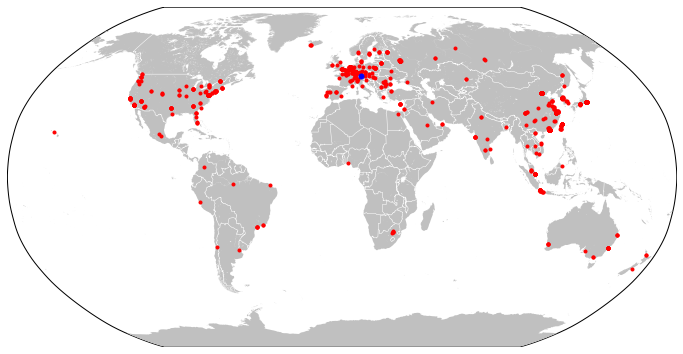

In [18]:
drawAllDoQResolver()

#### Slowest QUIC Resolvers

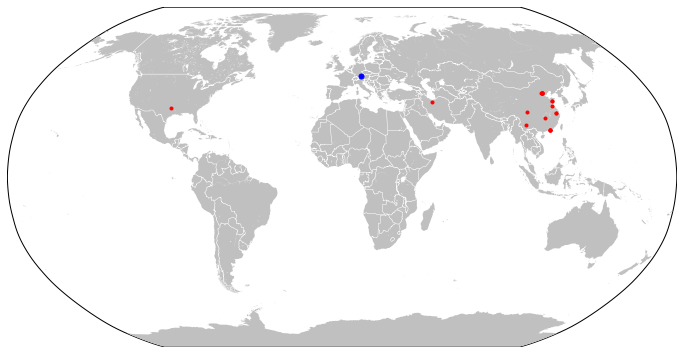

In [19]:
drawSlowestForProtocol("quic")

<br>
<br>
<br>
<br>

## ASN

In [20]:
getASN()

,ASN,size,ASN Name
104,31898,48,ORACLE-BMC-31898
119,37963,46,CNNIC-ALIBABA-CN-NET-AP
79,20473,37,AS-CHOOPA
135,42473,34,AS-ANEXIA
142,45090,33,CNNIC-TENCENT-NET-AP
202,132203,28,TENCENT-NET-AP-CN
64,16276,26,OVH
57,14061,25,DIGITALOCEAN-ASN
116,36352,21,AS-COLOCROSSING
59,15169,20,GOOGLE


<br>
<br>
<br>
<br>

## Adoption

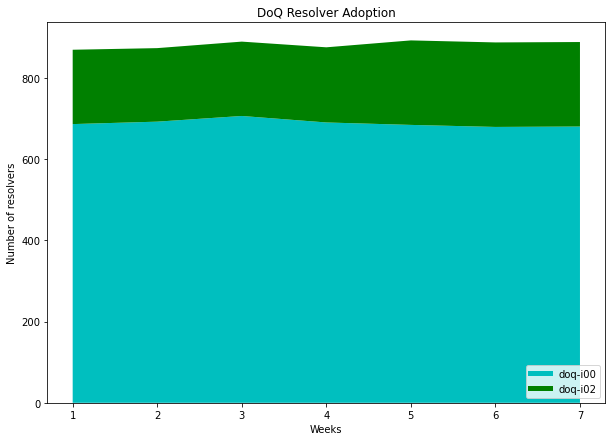

|   Week |   doq-i00 |   doq-i02 |   Total |
|-------:|----------:|----------:|--------:|
|      1 |       686 |       183 |     869 |
|      2 |       692 |       181 |     873 |
|      3 |       706 |       183 |     889 |
|      4 |       690 |       185 |     875 |
|      5 |       684 |       208 |     892 |
|      6 |       679 |       208 |     887 |
|      7 |       680 |       208 |     888 |


In [3]:
fig = plt.figure(figsize = (10, 7))

doq00 = [686, 692, 706, 690, 684, 679, 680]
doq02 = [183, 181, 183, 185, 208, 208, 208]
total = [x + y for (x, y) in zip(doq00, doq02)]

plt.plot([], [], color="c", label="doq-i00", linewidth=5)
plt.plot([], [], color="g", label="doq-i02", linewidth=5)

plt.stackplot([1, 2, 3, 4, 5, 6, 7], doq00, doq02, colors=["c", "g"])
plt.xlabel("Weeks")
plt.ylabel("Number of resolvers")
plt.title("DoQ Resolver Adoption")
plt.xticks([1, 2, 3, 4, 5, 6, 7])

plt.legend(loc = "lower right")
plt.show()

print(pd.DataFrame({ "Week": [1, 2, 3, 4, 5, 6, 7], "doq-i00": doq00, "doq-i02": doq02, "Total": total }).set_index("Week").to_markdown())

<br>
<br>
<br>
<br>

## UDP

In [22]:
print(getRCodeCountForProtocol("udp").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   18259 |
|        2 |     133 |
|        3 |     284 |
|        5 |     515 |


In [23]:
print(getErrorSuccessCountForProtocol("udp").to_markdown())

| status     |        count |
|:-----------|-------------:|
| success    | 19191        |
| error      |  2557        |
| error_rate |     0.117574 |


#### All errors

In [24]:
print(getTotalErrorsCategorized("udp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |    4033 |
| timeout            |   27859 |
| no_route           |      36 |
| overflow           |       7 |


#### Errors for Successful Servers

In [25]:
print(getErrorsCategorized("udp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     386 |
| timeout            |    2142 |
| overflow           |       7 |
| no_route           |      22 |


<br>
<br>
<br>
<br>

## TCP

In [26]:
print(getRCodeCountForProtocol("tcp").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   18134 |
|        2 |     128 |
|        3 |     293 |
|        5 |     631 |


In [27]:
print(getErrorSuccessCountForProtocol("tcp").to_markdown())

| status     |        count |
|:-----------|-------------:|
| success    | 19186        |
| error      |  2431        |
| error_rate |     0.112458 |


#### All errors

In [28]:
print(getTotalErrorsCategorized("tcp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |    4714 |
| timeout            |   26865 |
| eof                |     183 |
| no_route           |      81 |


#### Errors for Successful Servers

In [29]:
print(getErrorsCategorized("tcp").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     460 |
| timeout            |    1929 |
| no_route           |      42 |


#### TCP Fast Open (TFO)

No servers were found with support for TFO

#### edns-tcp-keepalive

12 resolvers were found to support edns-tcp-keepalive. They are all part of the AdGuard Organization. The timeout value returned for all of them is 0 meaning to close the connection after having received the response.

<br>
<br>
<br>
<br>

## TLS

In [30]:
print(getRCodeCountForProtocol("tls").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   34792 |
|        2 |     149 |
|        3 |     408 |
|        5 |     141 |


In [31]:
print(getErrorSuccessCountForProtocol("tls").to_markdown())

| status     |        count |
|:-----------|-------------:|
| success    | 35490        |
| error      |  4757        |
| error_rate |     0.118195 |


#### All errors

In [32]:
print(getTotalErrorsCategorized("tls").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |    2102 |
| timeout            |   13177 |
| unrecognized_name  |      59 |
| no_route           |      86 |
| tls_internal_error |      11 |


#### Errors for Successful Servers

In [33]:
print(getErrorsCategorized("tls").to_markdown())

| error              |   count |
|:-------------------|--------:|
| connection_refused |     594 |
| timeout            |    4095 |
| no_route           |      57 |
| tls_internal_error |      11 |


#### TLS Versions

In [34]:
print(getTLSVersions("tls").to_markdown())

|   tls_version |   count |
|--------------:|--------:|
|           772 |   35490 |


<br>
<br>
<br>
<br>

## HTTPS

In [35]:
print(getRCodeCountForProtocol("https").to_markdown())

|   r_code |   count |
|---------:|--------:|
|        0 |   23013 |
|        2 |     118 |
|        3 |     396 |
|        5 |      24 |


In [36]:
print(getErrorSuccessCountForProtocol("https").to_markdown())

| status     |         count |
|:-----------|--------------:|
| success    | 23551         |
| error      |  1530         |
| error_rate |     0.0610024 |


#### All errors

In [37]:
print(getTotalErrorsCategorized("https").to_markdown())

| error                 |   count |
|:----------------------|--------:|
| connection_refused    |    4132 |
| request_canceled      |    5373 |
| timeout               |     909 |
| overflow              |    4244 |
| eof                   |     406 |
| tls_internal_error    |    1062 |
| stream_error          |     732 |
| bad_rdata             |     611 |
| too_many_redirect     |     109 |
| connection_reset      |     114 |
| tls_handshake_failure |     236 |
| http_response         |     222 |
| no_route              |      57 |
| unrecognized_name     |     118 |


#### Errors for Successful Servers

In [38]:
print(getErrorsCategorized("https").to_markdown())

| error              |   count |
|:-------------------|--------:|
| request_canceled   |     743 |
| overflow           |     267 |
| tls_internal_error |      23 |
| connection_refused |     329 |
| timeout            |     126 |
| no_route           |      23 |


#### TLS Versions

In [39]:
print(getTLSVersions("https").to_markdown())

|   tls_version |   count |
|--------------:|--------:|
|           771 |     332 |
|           772 |   23219 |


#### HTTP Version

In [40]:
print(getHTTPVersion().to_markdown())

| http_version   |   count |
|:---------------|--------:|
| HTTP/1.1       |     353 |
| HTTP/2.0       |   23198 |


<br>
<br>
<br>
<br>

## Maps

#### Slowest UDP Resolvers

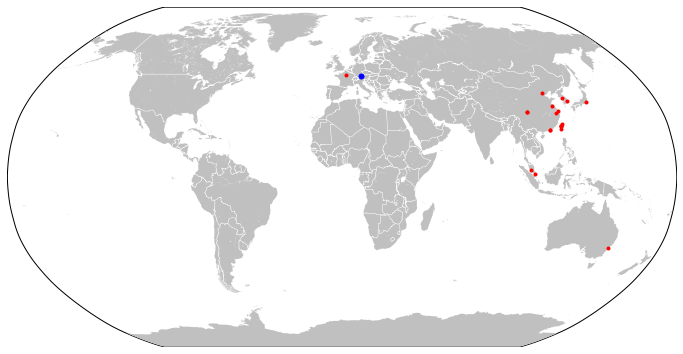

In [41]:
drawSlowestForProtocol("udp")

#### Slowest TCP Resolvers

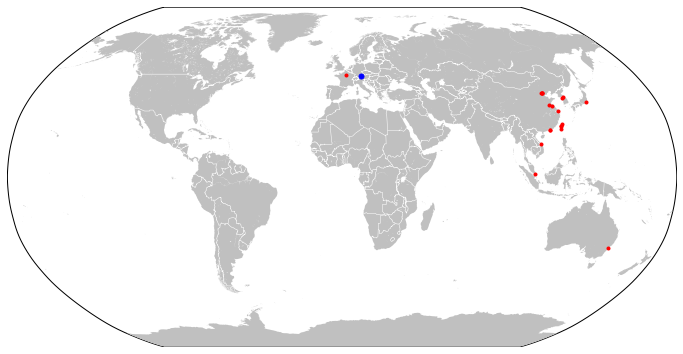

In [42]:
drawSlowestForProtocol("tcp")

#### Slowest TLS Resolvers

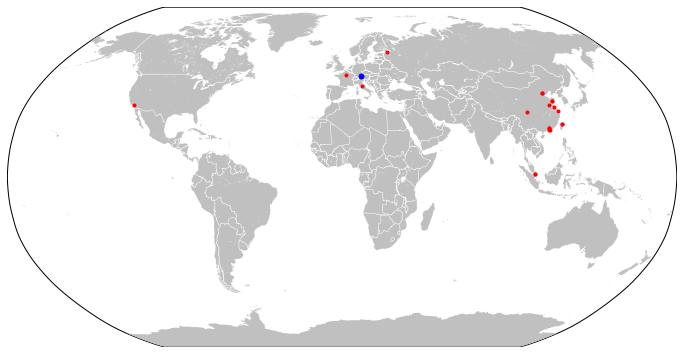

In [43]:
drawSlowestForProtocol("tls")

#### Slowest HTTPS Resolvers

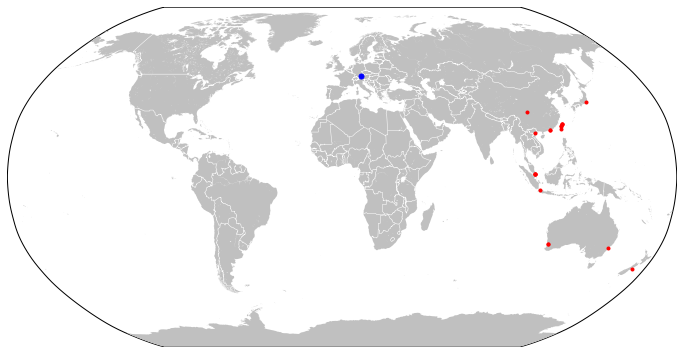

In [44]:
drawSlowestForProtocol("https")

<br>
<br>
<br>
<br>